<a href="https://colab.research.google.com/github/arjvik/BEEHealthy/blob/master/TrainModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup
!nvidia-smi
%pip -q install dvc fastds dvclive autokeras
!fds clone https://dagshub.com/arjvik/BEEHealthy
%cd BEEHealthy
!wget -q https://raw.githubusercontent.com/DeepVoltaire/AutoAugment/master/{autoaugment,ops}.py

Mon Mar 21 16:34:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Load dataframe
import numpy as np
import pandas as pd
df = pd.read_csv('bee_data.csv')

df["healthy"] = df.health == "healthy"
df["group"] = pd.to_numeric(df.file.str.split("_", n=1, expand=True)[0])
df

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,healthy,group
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,False,41
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,False,41
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,False,41
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,False,41
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,False,41
...,...,...,...,...,...,...,...,...,...,...,...
5167,027_011.png,8/20/18,10:03,"San Jose, CA, USA",95124,-1,healthy,True,worker,True,27
5168,027_007.png,8/20/18,10:03,"San Jose, CA, USA",95124,-1,healthy,True,worker,True,27
5169,027_013.png,8/20/18,10:03,"San Jose, CA, USA",95124,-1,healthy,False,worker,True,27
5170,027_012.png,8/20/18,10:03,"San Jose, CA, USA",95124,-1,healthy,False,worker,True,27


In [3]:
# Visualize dataset
import matplotlib.pyplot as plt

def view_dataset(ds):
    """https://colab.research.google.com/github/albumentations-team/albumentations_examples/blob/colab/tensorflow-example.ipynb"""
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(16, 16))
    plt.suptitle(repr(ds))
    for i in range(16):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Healthy: {label[i]}")

In [4]:
# Setup tf.data pipeline
import tensorflow as tf
from autoaugment import ImageNetPolicy
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import array_to_img, img_to_array

def load_images(filenames, labels):
    images = tf.io.decode_png(tf.io.read_file(filenames), channels=3)
    images = tf.image.resize(tf.cast(images, tf.float32), size=(224, 224))
    labels = tf.cast(labels, tf.bool)
    return images, labels

policy = ImageNetPolicy()
augment = lambda images: img_to_array(policy(array_to_img(images))) # convert to PIL image and back

def augment_images(images, labels):
    old_shape = images.shape
    images = tf.numpy_function(augment, [images], tf.float32)
    images.set_shape(old_shape)
    return images, labels

def preprocess_images(images, labels):
    images = preprocess_input(images)
    return images, labels

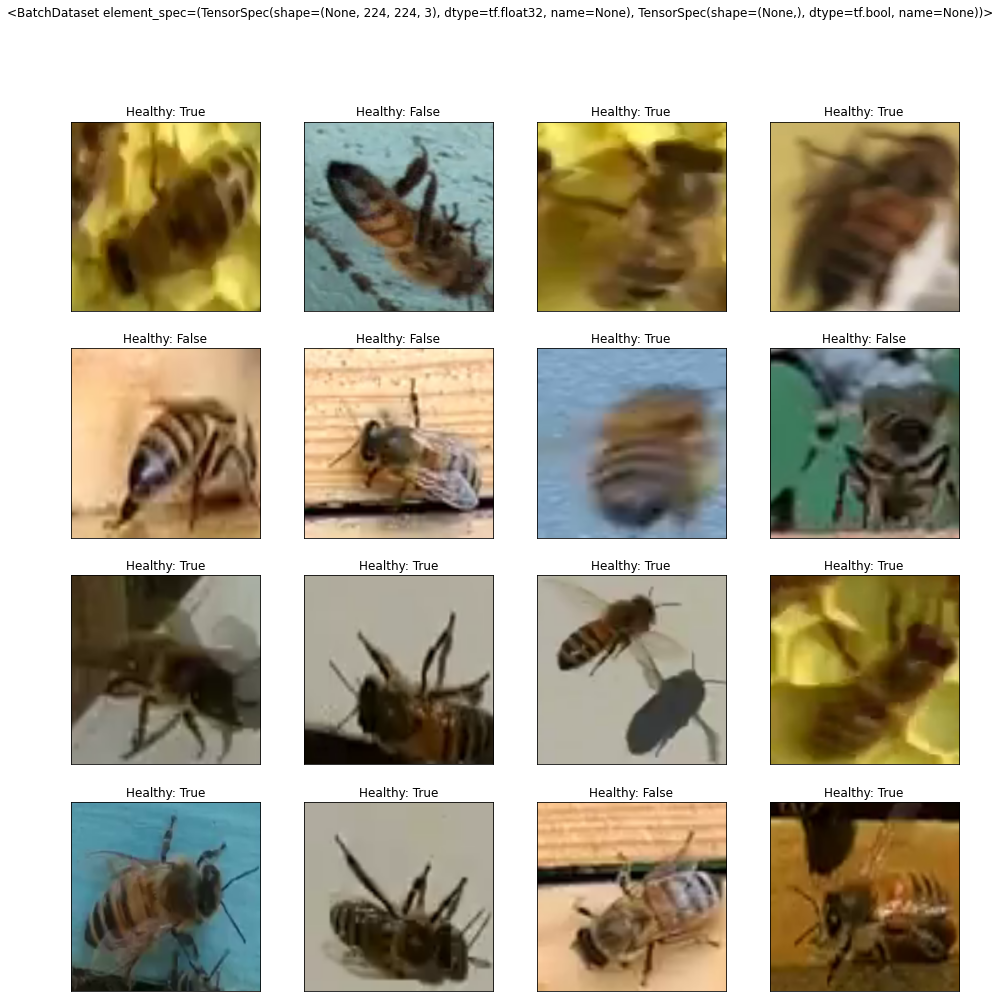

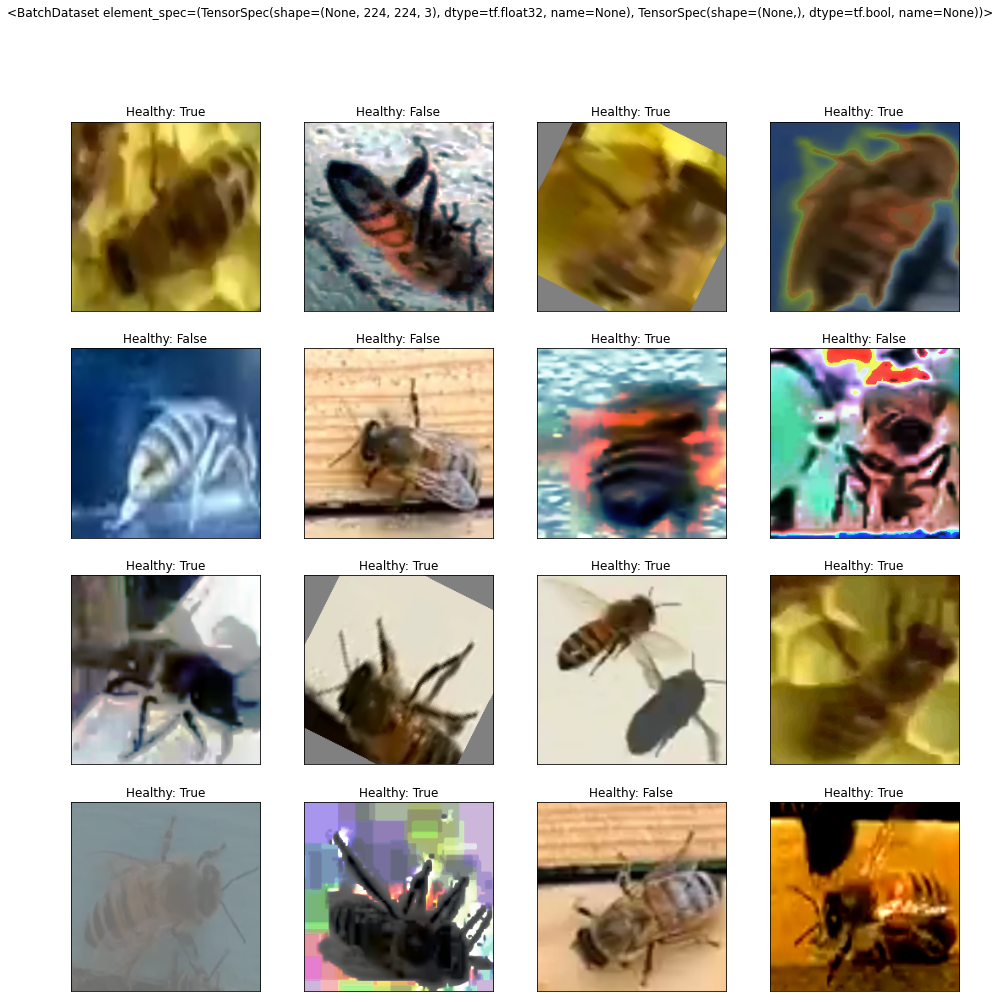

In [5]:
# Test tf.data pipeline
demo_ds = (Dataset.from_tensor_slices(("bee_imgs/" + df["file"], df["healthy"]))
                  .shuffle(buffer_size=1000, seed=0, reshuffle_each_iteration=False)
                  .map(load_images)
                  .cache())
view_dataset(demo_ds.map(lambda i, l: (i/255, l)).batch(16))
view_dataset(demo_ds.map(augment_images).map(lambda i, l: (i/255, l)).batch(16))

In [6]:
from sklearn.model_selection import StratifiedGroupKFold

fold_datasets = []

for train_idx, test_idx in (StratifiedGroupKFold(n_splits=3).split(df.file, df.healthy, df.group)):
    train_df = df.iloc[train_idx].copy()
    test_df = df.iloc[test_idx].copy()

    train_ds = (Dataset.from_tensor_slices(("bee_imgs/" + train_df["file"], train_df["healthy"]))
                       .map(load_images)
                       .cache()
                       .map(augment_images)
                       .map(preprocess_images)
                       .shuffle(buffer_size=10000)
                       .batch(32)
                       .prefetch(AUTOTUNE))

    test_ds = (Dataset.from_tensor_slices(("bee_imgs/" + test_df["file"], test_df["healthy"]))
                       .map(load_images)
                       .map(preprocess_images)
                       .cache()
                       .batch(32)
                       .prefetch(AUTOTUNE))

    fold_datasets.append((train_ds, test_ds))

In [7]:
from functools import partial, reduce
# from tensorflow.keras import Sequential, Model
# from tensorflow.keras.activations import sigmoid
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.mixed_precision import set_global_policy
# from tensorflow.keras.optimizers import Adam

from autokeras import ImageClassifier

compose = partial(reduce, lambda f, g: lambda *args: f(g(*args)))

# Faster training on Nvidia GPUs
set_global_policy('mixed_float16')

def get_model(name=None):
    # base_model = ResNet50(weights="imagenet", include_top=False, pooling='avg')
    # # base_model.trainable = False # TODO: unfreeze somewhere between ~10 epochs and -10 epochs
    # input = Input(shape=(224, 224, 3), name='input')
    # bottleneck = base_model(input, training=True)
    # output = Dense(1, activation=sigmoid, name='dense')(bottleneck)
    # model = Model(input, output, name=name)

    model = ImageClassifier(
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy(), Precision(), Recall()],
        project_name=name,
        max_trials=10
    )

    # model.compile(
    #     optimizer=Adam(learning_rate=1e-5),
    #     loss=BinaryCrossentropy(),
    #     metrics=[BinaryAccuracy(), Precision(), Recall()]
    # )
    
    return model
# get_model().summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [8]:
# from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

def get_callbacks(fold):
    return []
    # return [
    #     TensorBoard(
    #         log_dir=f'tensorboard/fold{fold}', histogram_freq=10, write_graph=True,
    #         write_images=True, write_steps_per_second=True, update_freq='epoch'
    #     ),
    #    ModelCheckpoint(filepath=f'fold{fold}-{{epoch:02d}}.h5', save_freq='epoch')
    # ]

In [ ]:
!rm -rf generated_imgs/
!mkdir -p generated_imgs/

for fold, (train_ds, test_ds) in zip(range(1, 4), fold_datasets):
    model = get_model(name=f'fold{fold}')
    model.fit(
        train_ds, validation_data=test_ds,
        callbacks=get_callbacks(fold),
        epochs=30
    )


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
vanilla           |?                 |image_block_1/block_type
True              |?                 |image_block_1/normalize
False             |?                 |image_block_1/augment
3                 |?                 |image_block_1/conv_block_1/kernel_size
1                 |?                 |image_block_1/conv_block_1/num_blocks
2                 |?                 |image_block_1/conv_block_1/num_layers
True              |?                 |image_block_1/conv_block_1/max_pooling
False             |?                 |image_block_1/conv_block_1/separable
0.25              |?                 |image_block_1/conv_block_1/dropout
32                |?                 |image_block_1/conv_block_1/filters_0_0
64                |?                 |image_block_1/conv_block_1/filters_0_1
flatten           |?                 |classification_head_1/spatial_reduction_1/reduction_type
0.5               |?            